## Project 3: Classification of Gender based on Names

This is a collaborative project conducted by the Fall 2017 students of DATA 620 at The City University of New York, in partial fulfillment of the requirements for the MS in Data Science degree.

### Problem Description

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?  

Source: Natural Language Processing with Python, exercise 6.10.2.  



### Contributors Include  

+ K. Joy Payton  
+ Keith Folsom  
+ Sonya Hong  
+ Shyam Balagurumurthy Viswanathan  
+ Derek Nokes  
+ Liam Byrne  
+ Latif Masud  
+ Valerie Briot  

### Importing the packages  

Since we all used Anaconda's Python version which comes pre-installed with most of the packages we need, we can simply import them into our notebook. textstat doesn't come with the base insallation, so we have to download it before importing it:

In [5]:
! pip install textstat

In [19]:
# Importing required libraries/packages
import nltk
from nltk.corpus import names
import random
import numpy
import pandas

from nltk.metrics import *

import re
    
import operator
import string
from textstat.textstat import textstat

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import itertools

# set display digits
display_digits=4


# inline matplotlib
%matplotlib inline

### Obtaining the Corpus

Note: If not already executed, nltk.download() will allow you access to the names corpus

In [9]:
nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\vbrio\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


True

To start, we will use NLTK's provided library of male and female names, and shuffle our dataset:

In [10]:
names = ([(name, 'male') for name in names.words('male.txt')] + \
         [(name, 'female') for name in names.words('female.txt')])

In [11]:
random_seed=1534678
random.seed(random_seed)
random.shuffle(names)

# let's see what the randomly shuffles names look like
names[1:10]

[(u'Edmund', 'male'),
 (u'Cariotta', 'female'),
 (u'Theresina', 'female'),
 (u'Mimi', 'female'),
 (u'Alecia', 'female'),
 (u'Jillayne', 'female'),
 (u'Godiva', 'female'),
 (u'Jeniffer', 'female'),
 (u'Tersina', 'female')]

### Create three subsets for development and error analysis of the models.

Now that we have our overall dataset, we will split out our data into three different subsets to be used for different purposes. There are 7944 names in the dataset, and we will first split the "names" data set into a Development set of 7,444 entries and a Test set of 500 entries.  

The Development set will be used to test each features as we build the module. This test will be split between a training set and a dev-test set.  

##### Development set:
* 6900 names for the training set
* 500 names for the dev-test set  

##### Test set:
* 500 names for the testing set

In [12]:
test_names, devtest_names, train_names = names[0:500], names[500:1000], names[1000:]

In [13]:
# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_names)))
print("Dev-Test Set = {}".format(len(devtest_names)))
print("Test Set = {}".format(len(test_names)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


### Data Set Exploration  

To determine the feature extractor function, we will first explore the data sets with respect to male and female features.  

We can see the the distribution of females and males in our training set as follows:

In [14]:
train_set_gold = [g  for (n, g) in train_names]
nltk.FreqDist(train_set_gold)

FreqDist({'female': 4348, 'male': 2596})

#### 1. First Letter  

A possible way to design a feature explorator would be to look at the first letter of the name.

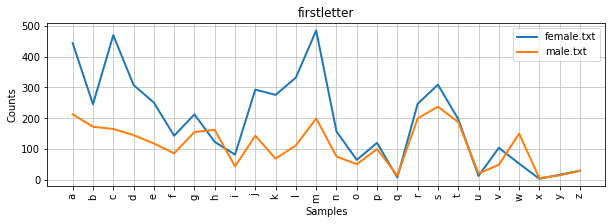

In [20]:
# firstletter
cfd_firstletter = nltk.ConditionalFreqDist((gender, name[0].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='firstletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_firstletter.plot()

We observe many more female names beginning with 'a', 'c', and 'm'.

#### 2. First 2 letters  

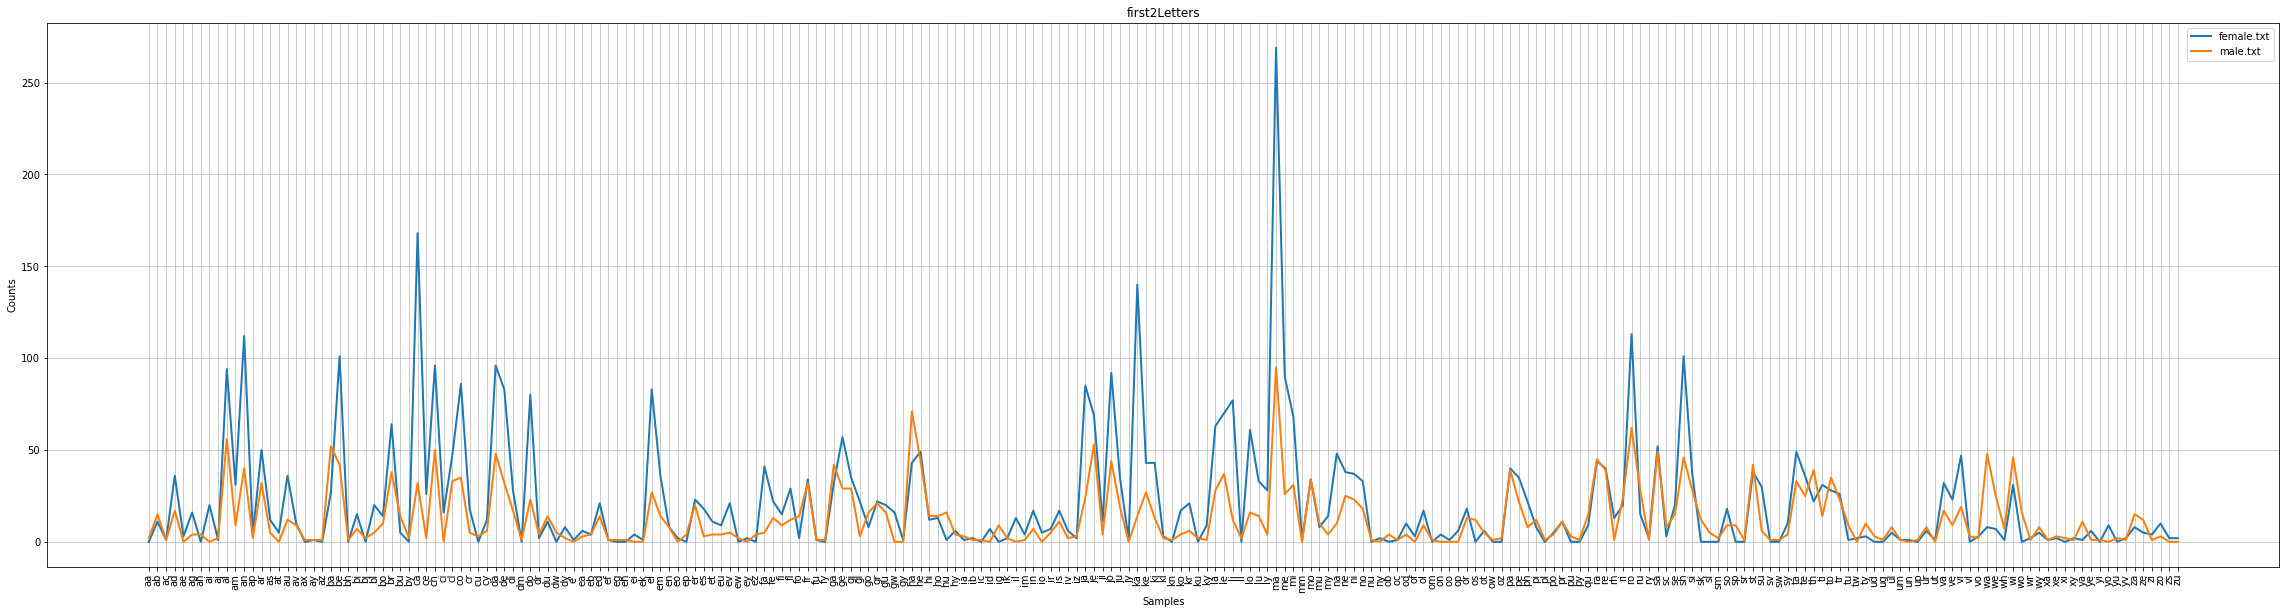

In [24]:
# first2Letters
cfd_first2Letters = nltk.ConditionalFreqDist((gender, name[0:2].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='first2Letters'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_first2Letters.plot()

#### 3. Last letter  

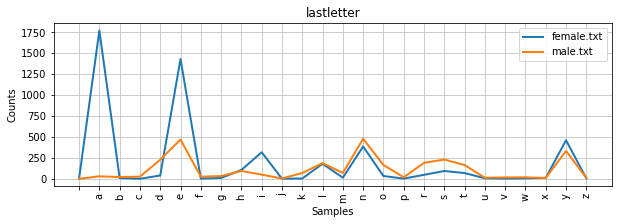

In [25]:
# lastletter
cfd_lastletter = nltk.ConditionalFreqDist((gender, name[-1].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='lastletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_lastletter.plot()

Names ending in the letters, 'a', 'e', or 'i' tend to be female, while the names ending in 's' are a bit more likely to be male.

#### 4. Length  

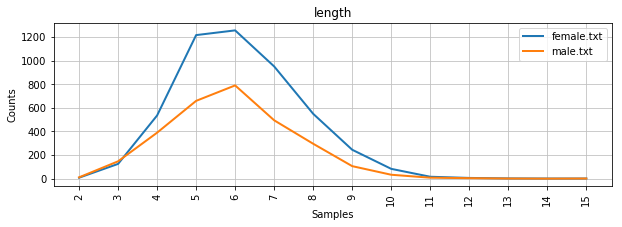

In [26]:
# length
cfd_length = nltk.ConditionalFreqDist((gender, len(name)) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_length.plot()

We can see (immediately above) that the the distributions of name length for female and male names are roughly the same shape and thus we would not expect our model to gain much predictive power from this feature set.

#### 5. Last 2 letters

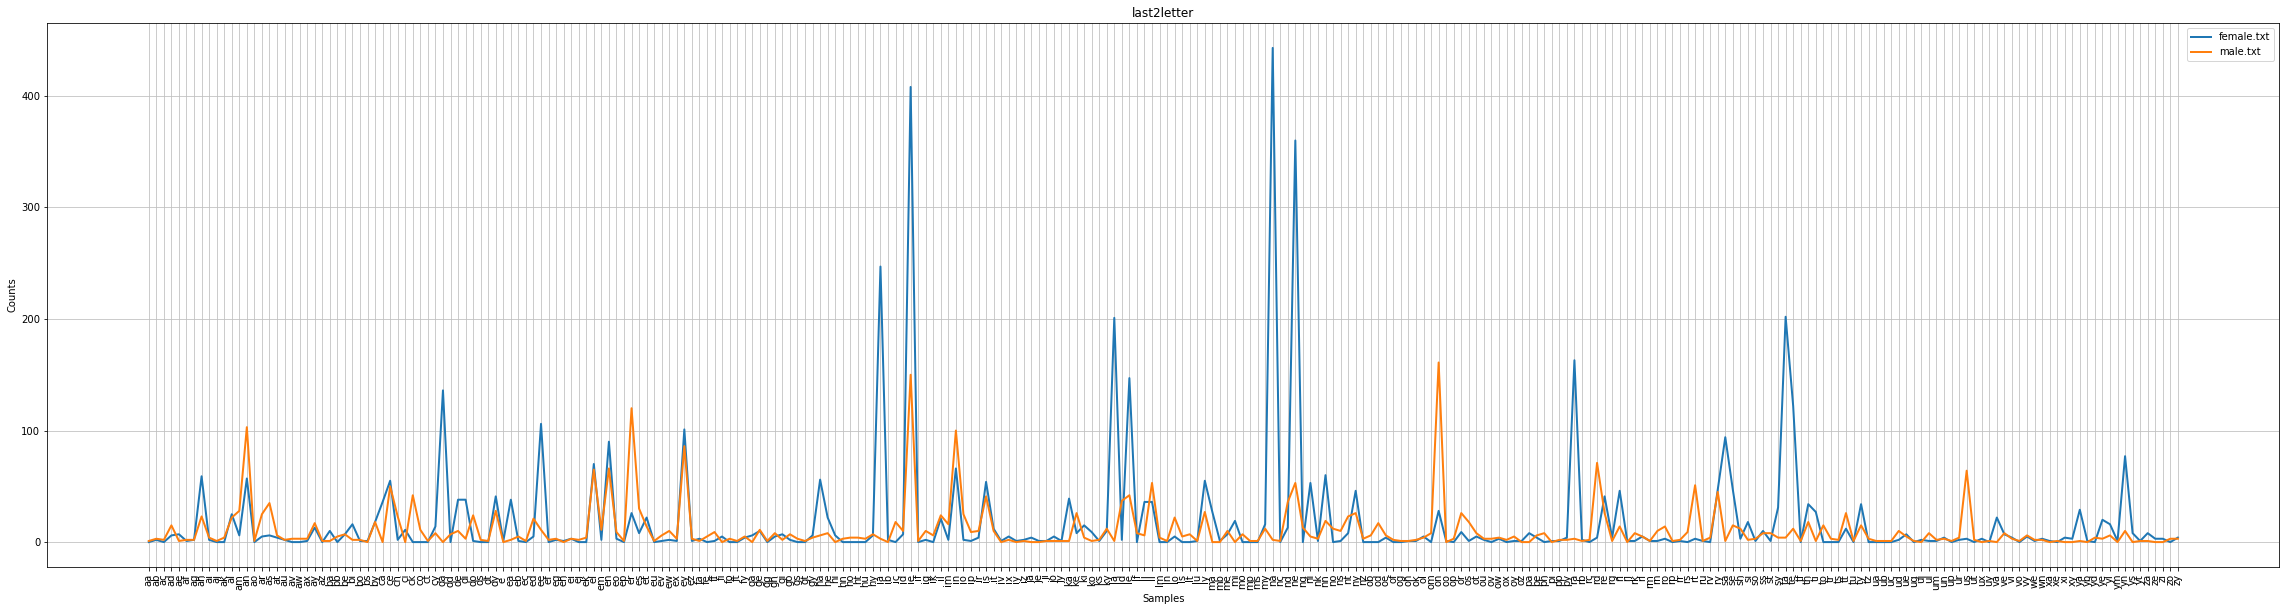

In [27]:
# last2letter
cfd_last2letter = nltk.ConditionalFreqDist((gender, name[-2:].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='last2letter'

# set figure size
plt.figure(figsize=(40,10))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_last2letter.plot()

From the distribution plot, it would appears that last 2 letters would be a good differentiator for male and female name.

#### 6. Last 3 letters

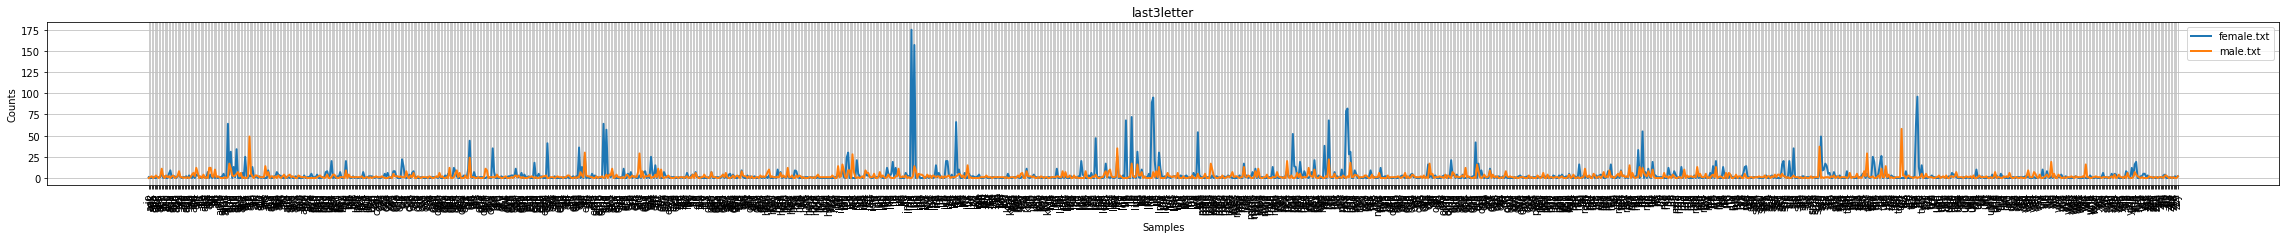

In [28]:
# last3letter
cfd_last3letter = nltk.ConditionalFreqDist((gender, name[-3:].lower()) for gender in names.fileids() for name in names.words(gender))

# define title
titleName='last3letter'

# set figure size
plt.figure(figsize=(40,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_last3letter.plot()

### Feature Extractor Functions

This section below is to incrementallly improve the feature extraction functions which are subsequently applied to the development and test datasets.  

Based on various example in the literature and analysis above, we will initiate our model building the the following features;  

1. First Letter, most names begining with a vowel are associated with females
2. First 2 letters
3. Last letter
4. Last 2 letters
5. Last 3 letters
6. Vowels count
7. Hard consonants using general rules of c and g
8. Soft consonants using general rules of c and g
9. Syllable Count of names via textstat
10. Name length
11. Character count
12. Character present
13. Count of each letter
14. Count of pair of letters in the alphabet

We built an function that will return a single feature or a combination of features based on input feature numbers


In [32]:
def get_features(name,feat_num):
    '''
    Parameters:
        name - string of name to extract feature
        feat_num - itterable collection of integers specifying features. *Defaults to 1:9 inclusive
            1: first letter
            2: first 2 letters
            3: last letter
            4: last 2 letters
            5: last 3 letters
            6: Vowel counts
            7: Hard consonant count
            8: Soft consonant count
            9: Syllable Count
            10: Name length
            11: char count --> feature for all alpha chars
            12: char present --> feature for all alpha chars (boolean)
            13: count each letter
            14: Count pairs
    Returns:
        features: a dictionary of extracted features
    '''
    features = {}    
        
    # Converts feat_num to itterable if type is int
    if type(feat_num) is int:
        feat_num = (0, feat_num)        
       
    # Gender Feature 1: First letter - book example
    if 1 in feat_num:
        features['firstletter'] = name[0].lower()
            
    # Gender Feature 2: First 2 letters
    if 2 in feat_num:
        features['first2Letters'] = name[0:2].lower()
            
    # Gender Feature 3: last letter
    if 3 in feat_num:
        features['last_letter'] = name[-1].lower()
            
    # Gender Feature 4: last 2 letter
    if 4 in feat_num:
        features["last2letters"] = name[-2:].lower()
        
    # Gender feature 5: last 3 letter
    if 5 in feat_num:  
        features["last3letters"] = name[-3:].lower()
            
    # Gender feature 6: Vowels count
    if 6 in feat_num:  
        features['vowel_count'] = len(re.sub(r'[^aeiou]', '', name.lower()))
            
    # Gender Feature 7: Hard consonants using general rules of c and g
    if 7 in feat_num:
        features['hard_consts'] = len(re.findall(r'[cg][^eiy]', name.lower()))/2
            
    # Gender Feature 8: Soft consonants using general rules of c and g
    if 8 in feat_num:
            features['soft_consts'] = len(re.findall(r'[cg][eiy]', name.lower()))/2
            
    # Gender Feature 9: Syllable Count of names via textstat
    if 9 in feat_num:
        features['syllable_count'] = textstat.syllable_count(name.lower())
    
    # Gender Feature 10: Name length
    if 10 in feat_num:
        features["length"] = len(name)
    
    # Gender Feature 11: Char Counts (overfitts)
    if 11 in feat_num:
        for letter in string.ascii_lowercase:
            features["count_{0}".format(letter)] = name.lower().count(letter)
                
    # Gender Feature 12: Char Booleans (overfitts)
    if 12 in feat_num:
        for letter in string.ascii_lowercase:
            features["has_{0}".format(letter)] = letter in name.lower()
        
        
    if 13 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter in letters:
            features["count(%s)" % letter] = name.lower().count(letter)


    if 14 in feat_num:
        features = {}
        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            for letter2 in letters:
                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())
        
    #### Complex Features
    # Gender Feature 15: Last Letter/Last 2 Letter
    if 15 in feat_num:
        features = {}
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
            
    if 16 in feat_num:
        features = {}
        features["firstletter"] = name[0].lower()
        features["lastletter"] = name[-1].lower()
        features["last2letter"] = name[-2:].lower()
        features["last3letter"] = name[-3:].lower()

        letters=list(map(chr, range(ord('a'), ord('z') + 1)))
        for letter1 in letters:
            features["count("+letter1+")"] = name.lower().count(letter1)
            features["has("+letter1+")"] = (letter1 in name.lower())
            # iterate over 2-grams
            for letter2 in letters:

                features["has("+letter1+letter2+")"] = (letter1+letter2 in name.lower())


    if 17 in feat_num:
        # define features
        features = {}
        # has(fo) = True
        features["has(fo)"] = ('fo' in name.lower())
        # has(hu) = True
        features["has(hu)"] = ('hu' in name.lower())
        # has(rv) = True
        features["has(rv)"] = ('rv' in name.lower())    
        # has(rw) = True
        features["has(rw)"] = ('rw' in name.lower()) 
        # has(sp) = True
        features["has(sp)"] = ('sp' in name.lower())

        # lastletter = 'a'
        features["lastletter=a"] = ('a' in name[-1:].lower())
        # lastletter = 'f'
        features["lastletter=f"] = ('f' in name[-1:].lower())
        # lastletter = 'k'
        features["lastletter=k"] = ('k' in name[-1:].lower())

        # last2letter = 'ch'
        features["last2letter=ch"] = ('ch' in name[-2:].lower())
        # last2letter = 'do'
        features["last2letter=do"] = ('do' in name[-2:].lower())
        # last2letter = 'ia'
        features["last2letter=ia"] = ('ia' in name[-2:].lower())
        # last2letter = 'im'
        features["last2letter=im"] = ('im' in name[-2:].lower())
        # last2letter = 'io'
        features["last2letter=io"] = ('io' in name[-2:].lower())
        # last2letter = 'la'
        features["last2letter=la"] = ('la' in name[-2:].lower())
        # last2letter = 'ld'
        features["last2letter=ld"] = ('ld' in name[-2:].lower())
        # last2letter = 'na'
        features["last2letter=na"] = ('na' in name[-2:].lower())
        # last2letter = 'os'
        features["last2letter=os"] = ('os' in name[-2:].lower())
        # last2letter = 'ra'
        features["last2letter=ra"] = ('ra' in name[-2:].lower())
        # last2letter = 'rd'
        features["last2letter=rd"] = ('rd' in name[-2:].lower())
        # last2letter = 'rt'
        features["last2letter=rt"] = ('rt' in name[-2:].lower())
        # last2letter = 'sa'
        features["last2letter=sa"] = ('sa' in name[-2:].lower())
        # last2letter = 'ta'
        features["last2letter=ta"] = ('ta' in name[-2:].lower())
        # last2letter = 'us'
        features["last2letter=us"] = ('us' in name[-2:].lower())

        # last3letter = 'ana'
        features["last3letter=ana"] = ('ana' in name[-3:].lower())    
        # last3letter = u'ard'
        features["last3letter=ard"] = ('ard' in name[-3:].lower())        
        # last3letter = u'ita'
        features["last3letter=ita"] = ('ita' in name[-3:].lower())    
        # last3letter = u'nne'
        features["last3letter=nne"] = ('nne' in name[-3:].lower())    
        # last3letter = u'tta'
        features["last3letter=tta"] = ('tta' in name[-3:].lower())    
        
    return features



### Functions for analysis and Helper functions

We built a few functions that will faciliate the analysis and the display of the results;

+ normalize_confusion_matrix: Returns a normalized confusion matrix  
+ plot_confusion_matrix: plot a confusion matrix 
+ plot_both_confusion_matrix: plot 2 confusion matrix side by side  
+ evaluate_naive_bayes_classifier: train a model using naive bayes classifier  
+ evaluate_decision_tree_classifier: train a model using decision tree classifier
+ get_sorted_feature_accuracies: Returns a tuple of sorted features and accuracies in the dataset.
+ optmized_solution: Returns a tuple of list of features that yield the highest accuracy, and the accuracy that was achieved.

Helper functions:  

+ generate_errors
+ show_errors
+ generate_prediction

In [99]:
### Functions for analysis
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

def evaluate_naive_bayes_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set) 
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier

def evaluate_decision_tree_classifier(train_names,devtest_names,test_names,feat_num):
    # create feature set (train)
    train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.DecisionTreeClassifier.train(train_set)
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n,feat_num))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)

    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier
 
    
def get_sorted_feature_accuracies(feat_num_start, feat_num, model_id):
        feature_accuracy = {}
        for i in np.arange(feat_num_start, feat_num+1):
            feat_num =int(i)
            errors = []
            
            # devtest-set and training set are constructed
            #random.shuffle(development_set_names)
            #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
            train_set = [(get_features(n,feat_num), g)  for (n, g) in train_names]
            devtest_set = [(get_features(n,feat_num), g)  for (n, g) in devtest_names]
            test_set = [(get_features(n,feat_num), g)  for (n, g) in test_names] 
            
            if (model_id == 'nbc'):
                classifier = nltk.NaiveBayesClassifier.train(train_set)
            elif (model_id == 'dtc'):
                classifier = nltk.DecisionTreeClassifier.train(train_set)
                  
            # For errors list
            for (name, tag) in devtest_names:
                guess = classifier.classify(get_features(name,feat_num)) 
                if guess != tag: 
                    errors.append((tag, guess, name))    
                    
            
            feature_accuracy[feat_num] = nltk.classify.accuracy(classifier, devtest_set)
        
        
        #sort for accuracy, and then reverse the array to return the array as most accurate to least accurate
        sorted_by_accuracy = sorted(feature_accuracy.items(), key=operator.itemgetter(1))
        return sorted_by_accuracy[::-1]
                  
def optimized_solution(model_id):
    # for each of the features, append to the list of features, and check if the accuracy
    #went up or down. If it went down, take it out, if it went up, make that the new accuracy to beat.
        
    optimized_feature_list = []
    last_accuracy = -1
    for feat_num in range(1,15):
        errors = []
        optimized_feature_list.append(feat_num)
            
        #random.shuffle(development_set_names)
        #devtest_names, train_names = development_set_names[0:500], development_set_names[500:]
            
        train_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in train_names]
        devtest_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in devtest_names]
        test_set = [(get_features(n,optimized_feature_list), g)  for (n, g) in test_names] 
            
        if (model_id == 'nbc'):
            classifier = nltk.NaiveBayesClassifier.train(train_set)
        elif (model_id == 'dtc'):
            classifier = nltk.DecisionTreeClassifier.train(train_set) 
            
        for (name, tag) in devtest_names:
            guess = classifier.classify(get_features(name,optimized_feature_list)) 
            if guess != tag: 
                errors.append((tag, guess, name))    
                    
            
        current_accuracy= nltk.classify.accuracy(classifier, devtest_set)
        if current_accuracy > last_accuracy: 
            last_accuracy = current_accuracy
        else:
            del optimized_feature_list[-1]
            
    return (optimized_feature_list, last_accuracy)     

### Helper functions:

# Generic function to generate an error list based the arguments provided
# Accepts the classifer, names dataset, and the extractor function
# Returns the list of errors

def generate_errors(classifier, dataset, feat_num): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name,feat_num)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

# Generic function to display classification errors
# Accepts the error list and an optional argument to show only n number of errors

def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

        
def generate_prediction(classifier, dataset, extractor_function): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        classification.append((name,guess))
            
    return classification

### Gender Identification Models - Naive Bayes Classifier: 

Using our previously identified simple features we will evaluate how the model perform for each.  

#### Feature 1 - First Letter

In this model, we train a Naive Bayes classifier using a simple feature set - namely the first letter of the name.

Accuracy (Train): 0.646745391705
Accuracy (Development Test): 0.656


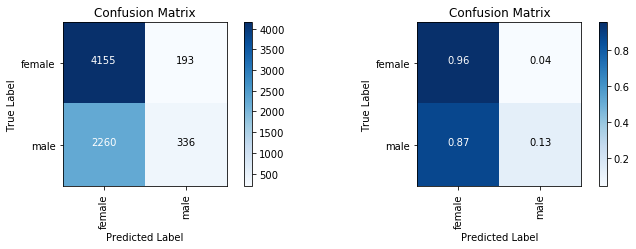

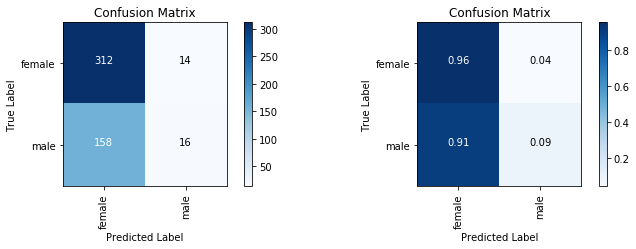

In [48]:
feat_num = 1
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb1,train_cm_nb1,train_label_names_nb1,train_report_nb1, \
    devtest_accuracy_nb1, devtest_cm_nb1,devtest_label_names_nb1, \
    devtest_report_nb1, classifier_nb1=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb1))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb1,['female','male'])

In [49]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb1)

Model Performance Metrics (Train):
             precision    recall  f1-score   support

     female     0.6477    0.9556    0.7721      4348
       male     0.6352    0.1294    0.2150      2596

avg / total     0.6430    0.6467    0.5638      6944

Model Performance Metrics (Development Test):
             precision    recall  f1-score   support

     female     0.6638    0.9571    0.7839       326
       male     0.5333    0.0920    0.1569       174

avg / total     0.6184    0.6560    0.5657       500



In [50]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb1.show_most_informative_features(n_informative_features)

Most Informative Features
             firstletter = u'w'             male : female =      4.8 : 1.0
             firstletter = u'q'             male : female =      2.5 : 1.0
             firstletter = u'x'             male : female =      2.4 : 1.0
             firstletter = u'k'           female : male   =      2.3 : 1.0
             firstletter = u'u'             male : female =      2.3 : 1.0
             firstletter = u'h'             male : female =      2.3 : 1.0
             firstletter = u'y'             male : female =      1.9 : 1.0
             firstletter = u'l'           female : male   =      1.7 : 1.0
             firstletter = u'c'           female : male   =      1.7 : 1.0
             firstletter = u't'             male : female =      1.7 : 1.0
             firstletter = u'z'             male : female =      1.5 : 1.0
             firstletter = u'p'             male : female =      1.5 : 1.0
             firstletter = u'm'           female : male   =      1.4 : 1.0

In [51]:
# Show error 
show_errors(generate_errors(classifier_nb1, devtest_names, feat_num))

correct=female   guess=male     name=Hannah                        
correct=female   guess=male     name=Hanni                         
correct=female   guess=male     name=Harli                         
correct=female   guess=male     name=Hatty                         
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Herta                         
correct=female   guess=male     name=Hilde                         
correct=female   guess=male     name=Hyacinthie                    
correct=female   guess=male     name=Quentin                       
correct=female   guess=male     name=Wilhelmine                    
correct=female   guess=male     name=Willabella                    
correct=female   guess=male     name=Willi                         
correct=female   guess=male     name=Wini                          
correct=female   guess=male     name=Yettie                        
correct=male     guess=female   name=Adlai      

First letter alone does not lead to very good results as is indicated by the analysis above.  

#### Feature 2 - First 2 letters  

We will now consider the first 2 letters as our feature.  


Accuracy (Train): 0.684907834101
Accuracy (Development Test): 0.672


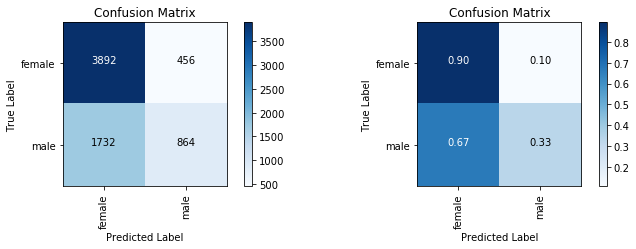

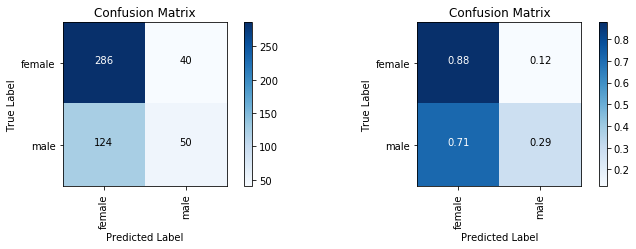

In [53]:
feat_num = 2
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb2,train_cm_nb2,train_label_names_nb2,train_report_nb2, \
    devtest_accuracy_nb2, devtest_cm_nb2,devtest_label_names_nb2, \
    devtest_report_nb2, classifier_nb2=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb2))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb2))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb2,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb2,['female','male'])

In [54]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb2.show_most_informative_features(n_informative_features)

Most Informative Features
           first2Letters = u'fo'            male : female =     15.9 : 1.0
           first2Letters = u'hu'            male : female =     13.7 : 1.0
           first2Letters = u'ya'            male : female =     12.6 : 1.0
           first2Letters = u'tu'            male : female =      9.3 : 1.0
           first2Letters = u'wa'            male : female =      8.6 : 1.0
           first2Letters = u'ce'          female : male   =      6.2 : 1.0
           first2Letters = u'ka'          female : male   =      6.1 : 1.0
           first2Letters = u'wh'            male : female =      6.0 : 1.0
           first2Letters = u'we'            male : female =      5.2 : 1.0
           first2Letters = u'fa'          female : male   =      5.1 : 1.0
           first2Letters = u'ty'            male : female =      4.9 : 1.0
           first2Letters = u'li'          female : male   =      4.6 : 1.0
           first2Letters = u'es'          female : male   =      4.3 : 1.0

In [55]:
# Show error 
show_errors(generate_errors(classifier_nb2, devtest_names, feat_num))

correct=female   guess=male     name=Babette                       
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Dulcinea                      
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gayleen                       
correct=female   guess=male     name=Gianina                       
correct=female   guess=male     name=Gilli                         
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Gisella                       
correct=female   guess=male     name=Giselle                       
correct=female   guess=male     name=Grazia                        
correct=female   guess=male     name=Greta                         
correct=female   guess=male     name=Grethel                       
correct=female   guess=male     name=Hannah     

First letters features are not good candidate for building model, we will now consider last letter(s) features.  

#### Feature 3 - Last letter

We will now focus on the last letter of the name. In our brief exploration of features, we observed some patterns that could likely be exploited by our classifier.

Accuracy (Train): 0.760512672811
Accuracy (Development Test): 0.762


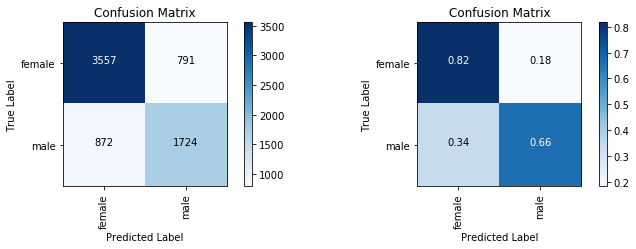

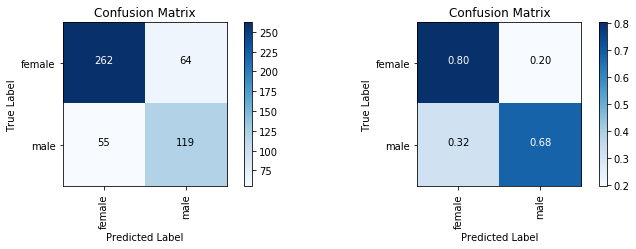

In [57]:
feat_num = 3
# evaluate the Naive Bayes classifier using gender_features1
train_accuracy_nb3,train_cm_nb3,train_label_names_nb3,train_report_nb3, \
    devtest_accuracy_nb3, devtest_cm_nb3,devtest_label_names_nb3, \
    devtest_report_nb3, classifier_nb3=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb3))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb3))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb3,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb3,['female','male'])

In [58]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb3.show_most_informative_features(n_informative_features)

Most Informative Features
             last_letter = u'k'             male : female =     39.8 : 1.0
             last_letter = u'a'           female : male   =     32.2 : 1.0
             last_letter = u'f'             male : female =     15.0 : 1.0
             last_letter = u'v'             male : female =     11.0 : 1.0
             last_letter = u'm'             male : female =      9.8 : 1.0
             last_letter = u'd'             male : female =      9.8 : 1.0
             last_letter = u'p'             male : female =      9.7 : 1.0
             last_letter = u'o'             male : female =      8.2 : 1.0
             last_letter = u'r'             male : female =      6.6 : 1.0
             last_letter = u'g'             male : female =      5.6 : 1.0
             last_letter = u'w'             male : female =      5.0 : 1.0
             last_letter = u'z'             male : female =      4.5 : 1.0
             last_letter = u's'             male : female =      4.2 : 1.0

In [59]:
show_errors(generate_errors(classifier_nb3, devtest_names, feat_num))

correct=female   guess=male     name=Ailyn                         
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Beatriz                       
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Eilis                         
correct=female   guess=male     name=Ellen                         
correct=female   guess=male     name=Eryn       

Although names ending in the letter 'a' is our second best feature in this feature set, the other rules that looked useful in gender prediction were not in the top of the list.

This is perhaps because we explored the conditional frequency, rather than the percent conditional frequency.

#### Feature 4 - Last 2 letters  

In this model, we train a Naive Bayes classifier using a feature set comprised of the first two letters of a name.

Accuracy (Train): 0.802419354839
Accuracy (Development Test): 0.786


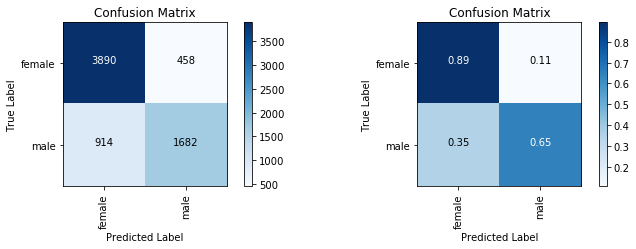

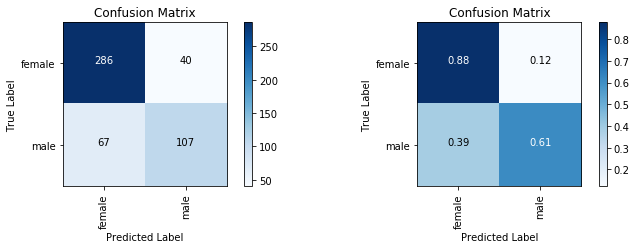

In [60]:
feat_num = 4
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb4,train_cm_nb4,train_label_names_nb4,train_report_nb4, \
    devtest_accuracy_nb4, devtest_cm_nb4,devtest_label_names_nb4, \
    devtest_report_nb4, classifier_nb4=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb4))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb4))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb4,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb4,['female','male'])

In [61]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb4.show_most_informative_features(n_informative_features)

Most Informative Features
            last2letters = u'na'          female : male   =     93.4 : 1.0
            last2letters = u'la'          female : male   =     70.0 : 1.0
            last2letters = u'ia'          female : male   =     38.9 : 1.0
            last2letters = u'ra'          female : male   =     34.0 : 1.0
            last2letters = u'sa'          female : male   =     33.9 : 1.0
            last2letters = u'rt'            male : female =     28.6 : 1.0
            last2letters = u'us'            male : female =     27.9 : 1.0
            last2letters = u'ld'            male : female =     23.3 : 1.0
            last2letters = u'ta'          female : male   =     22.9 : 1.0
            last2letters = u'rd'            male : female =     22.8 : 1.0
            last2letters = u'os'            male : female =     18.1 : 1.0
            last2letters = u'im'            male : female =     17.0 : 1.0
            last2letters = u'io'            male : female =     16.1 : 1.0

In [62]:
# Show error 
show_errors(generate_errors(classifier_nb4, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Ange                          
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Charil                        
correct=female   guess=male     name=Coral                         
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Jacquelin  

Feature utilizating last letter(s) leads better results so far.  

#### Feature 5 - Last 3 Letters  

In this model, we train a Naive Bayes classifier using the last three letters of the name.

Accuracy (Train): 0.857430875576
Accuracy (Development Test): 0.768


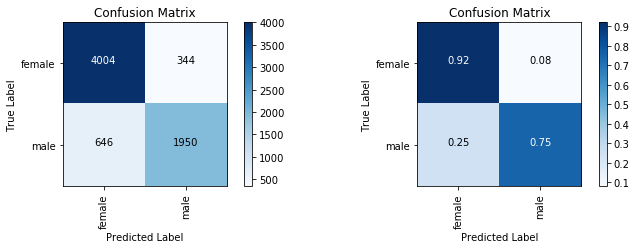

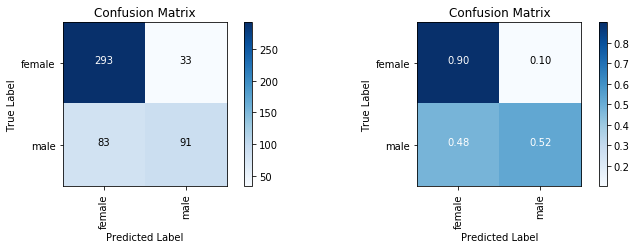

In [63]:
feat_num = 5
# evaluate the Naive Bayes classifier using gender_features5
train_accuracy_nb5,train_cm_nb5,train_label_names_nb5,train_report_nb5, \
    devtest_accuracy_nb5, devtest_cm_nb5,devtest_label_names_nb5, \
    devtest_report_nb5, classifier_nb5=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb5))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb5))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb5,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb5,['female','male'])

In [64]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb5.show_most_informative_features(n_informative_features)

Most Informative Features
            last3letters = u'nne'         female : male   =     28.8 : 1.0
            last3letters = u'ana'         female : male   =     24.1 : 1.0
            last3letters = u'tta'         female : male   =     22.8 : 1.0
            last3letters = u'ard'           male : female =     20.0 : 1.0
            last3letters = u'old'           male : female =     16.9 : 1.0
            last3letters = u'ert'           male : female =     15.7 : 1.0
            last3letters = u'ita'         female : male   =     15.0 : 1.0
            last3letters = u'ela'         female : male   =     14.1 : 1.0
            last3letters = u'dra'         female : male   =     12.8 : 1.0
            last3letters = u'ria'         female : male   =     12.8 : 1.0
            last3letters = u'vin'           male : female =     12.0 : 1.0
            last3letters = u'son'           male : female =     10.4 : 1.0
            last3letters = u'nni'         female : male   =      9.8 : 1.0

In [65]:
# Show error 
show_errors(generate_errors(classifier_nb5, devtest_names, feat_num))

correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Carey                         
correct=female   guess=male     name=Carole                        
correct=female   guess=male     name=Dale                          
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Ginger                        
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Jan                           
correct=female   guess=male     name=Jenn                          
correct=female   guess=male     name=Jillian                       
correct=female   guess=male     name=Joell                         
correct=female   guess=male     name=Jorey                         
correct=female   guess=male     name=Kiersten   

#### Feature 6 - Vowels Count  

In this model, we train a Naive Bayes classifier using the vowel count.

Accuracy (Train): 0.628456221198
Accuracy (Development Test): 0.658


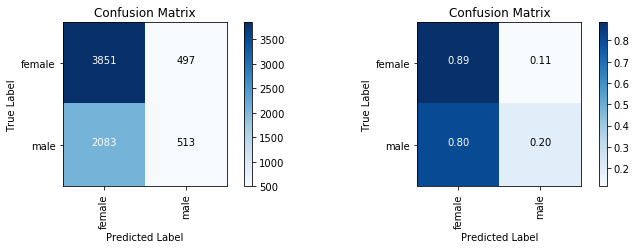

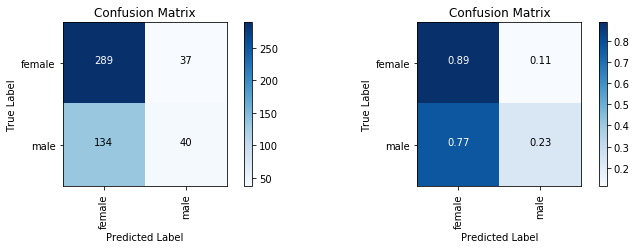

In [66]:
feat_num = 6
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb6,train_cm_nb6,train_label_names_nb6,train_report_nb6, \
    devtest_accuracy_nb6, devtest_cm_nb6,devtest_label_names_nb6, \
    devtest_report_nb6, classifier_nb6=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb6))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb6))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb6,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb6,['female','male'])

In [54]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb6.show_most_informative_features(n_informative_features)

Most Informative Features
           first2Letters = u'fo'            male : female =     15.9 : 1.0
           first2Letters = u'hu'            male : female =     13.7 : 1.0
           first2Letters = u'ya'            male : female =     12.6 : 1.0
           first2Letters = u'tu'            male : female =      9.3 : 1.0
           first2Letters = u'wa'            male : female =      8.6 : 1.0
           first2Letters = u'ce'          female : male   =      6.2 : 1.0
           first2Letters = u'ka'          female : male   =      6.1 : 1.0
           first2Letters = u'wh'            male : female =      6.0 : 1.0
           first2Letters = u'we'            male : female =      5.2 : 1.0
           first2Letters = u'fa'          female : male   =      5.1 : 1.0
           first2Letters = u'ty'            male : female =      4.9 : 1.0
           first2Letters = u'li'          female : male   =      4.6 : 1.0
           first2Letters = u'es'          female : male   =      4.3 : 1.0

In [67]:
# Show error 
show_errors(generate_errors(classifier_nb6, devtest_names, feat_num))

correct=female   guess=male     name=Anny                          
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Bliss                         
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Cybal                         
correct=female   guess=male     name=Darby                         
correct=female   guess=male     name=Darcy                         
correct=female   guess=male     name=Deny                          
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Eryn                          
correct=female   guess=male     name=Glad                          
correct=female   guess=male     name=Hatty                         
correct=female   guess=male     name=Jan        

This feature is not leading as good results as last letter features.  

#### Feature 7 - Hard Consonant using general rules of c and g  

In this model, we train a Naive Bayes classifier based on hard consonants using general rules of 'c' and 'g'.

Accuracy (Train): 0.626440092166
Accuracy (Development Test): 0.654


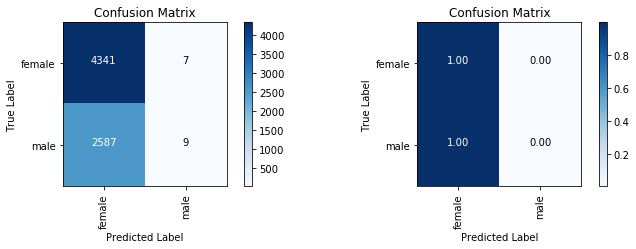

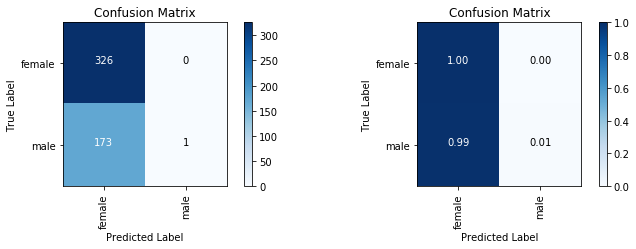

In [68]:
feat_num = 7
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb7,train_cm_nb7,train_label_names_nb7,train_report_nb7, \
    devtest_accuracy_nb7, devtest_cm_nb7,devtest_label_names_nb7, \
    devtest_report_nb7, classifier_nb7=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb7))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb7))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb7,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb7,['female','male'])

In [69]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb7.show_most_informative_features(n_informative_features)

Most Informative Features
             hard_consts = 1                male : female =      2.1 : 1.0
             hard_consts = 0              female : male   =      1.0 : 1.0


In [70]:
# Show error 
show_errors(generate_errors(classifier_nb7, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

Again, this feature does not look promising as a first feature to build our model on.  

#### Feature 8 - Soft Consonant using general rules of c and g  

In this model, we train a Naive Bayes classifier based on soft consonants using general rules of 'c' and 'g'.

C:\Users\vbrio\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


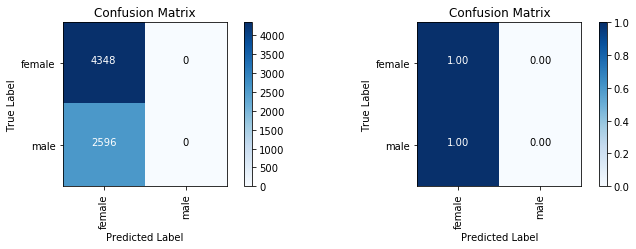

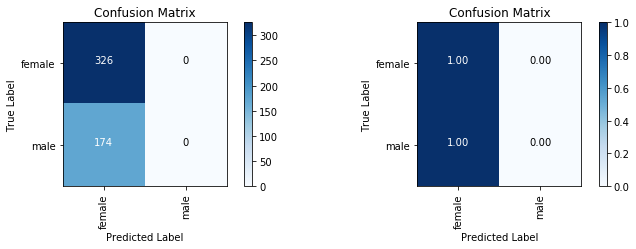

In [71]:
feat_num = 8
# evaluate the Naive Bayes classifier using gender_features8
train_accuracy_nb8,train_cm_nb8,train_label_names_nb8,train_report_nb8, \
    devtest_accuracy_nb8, devtest_cm_nb8,devtest_label_names_nb8, \
    devtest_report_nb8, classifier_nb8=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb8))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb8))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb8,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb8,['female','male'])

In [72]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb8.show_most_informative_features(n_informative_features)

Most Informative Features
             soft_consts = 1              female : male   =      2.0 : 1.0
             soft_consts = 0                male : female =      1.0 : 1.0


In [73]:
# Show error 
show_errors(generate_errors(classifier_nb8, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

#### Feature 9 - Syllable Count  

In this model, we train a Naive Bayes classifier using the syllable count.

Accuracy (Train): 0.626152073733
Accuracy (Development Test): 0.652


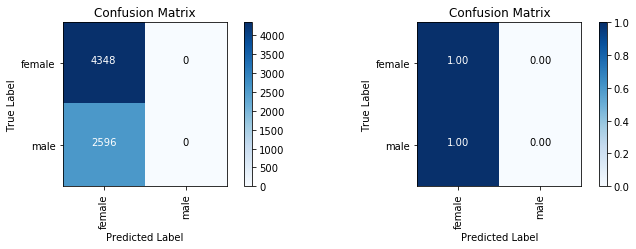

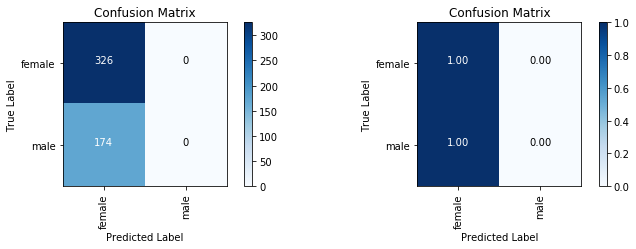

In [74]:
feat_num = 9
# evaluate the Naive Bayes classifier using gender_features9
train_accuracy_nb9,train_cm_nb9,train_label_names_nb9,train_report_nb9, \
    devtest_accuracy_nb9, devtest_cm_nb9,devtest_label_names_nb9, \
    devtest_report_nb9, classifier_nb9=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb9))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb9))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb9,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb9,['female','male'])

In [75]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb9.show_most_informative_features(n_informative_features)

Most Informative Features
          syllable_count = 3.6            female : male   =      3.1 : 1.0
          syllable_count = 2.7            female : male   =      2.0 : 1.0
          syllable_count = 0.9              male : female =      1.5 : 1.0
          syllable_count = 1.8              male : female =      1.2 : 1.0


In [76]:
# Show error 
show_errors(generate_errors(classifier_nb9, devtest_names, feat_num))

correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Al                            
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford                        
correct=male     guess=female   name=Alfredo                       
correct=male     guess=female   name=Ali                           
correct=male     guess=female   name=Amery                         
correct=male     guess=female   name=Anatollo                      
correct=male     guess=female   name=Antony                        
correct=male     guess=female   name=Arnoldo                       
correct=male     guess=female   name=Barthel                       
correct=male     guess=female   name=Basil                         
correct=male     guess=female   name=Bentley    

#### Feature 10 - Name Length  

In this model, we train a Naive Bayes classifier using the name length.

Accuracy (Train): 0.628744239631
Accuracy (Development Test): 0.66


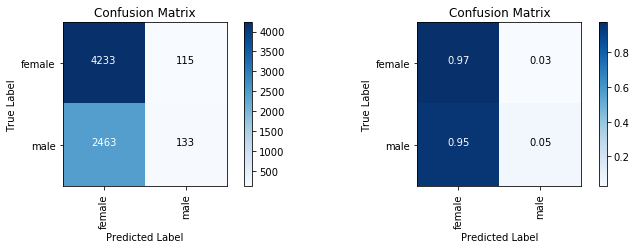

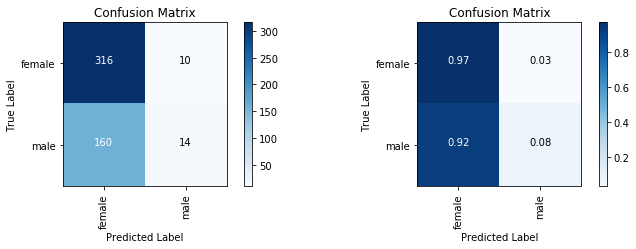

In [77]:
feat_num = 10
# evaluate the Naive Bayes classifier using gender_features10
train_accuracy_nb10,train_cm_nb10,train_label_names_nb10,train_report_nb10, \
    devtest_accuracy_nb10, devtest_cm_nb10,devtest_label_names_nb10, \
    devtest_report_nb10, classifier_nb10=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb10))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb10))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb10,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb10,['female','male'])

In [78]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb10.show_most_informative_features(n_informative_features)

Most Informative Features
                  length = 2                male : female =      2.1 : 1.0
                  length = 3                male : female =      1.9 : 1.0
                  length = 15               male : female =      1.7 : 1.0
                  length = 9              female : male   =      1.4 : 1.0
                  length = 10             female : male   =      1.4 : 1.0
                  length = 12               male : female =      1.4 : 1.0
                  length = 4                male : female =      1.2 : 1.0
                  length = 7              female : male   =      1.1 : 1.0
                  length = 8              female : male   =      1.1 : 1.0
                  length = 6                male : female =      1.1 : 1.0
                  length = 5              female : male   =      1.1 : 1.0
                  length = 11             female : male   =      1.0 : 1.0
                  length = 13               male : female =      1.0 : 1.0

In [79]:
# Show error 
show_errors(generate_errors(classifier_nb10, devtest_names, feat_num))

correct=female   guess=male     name=Jan                           
correct=female   guess=male     name=Kay                           
correct=female   guess=male     name=Kia                           
correct=female   guess=male     name=Lee                           
correct=female   guess=male     name=Mag                           
correct=female   guess=male     name=May                           
correct=female   guess=male     name=Pam                           
correct=female   guess=male     name=Pen                           
correct=female   guess=male     name=Pet                           
correct=female   guess=male     name=Tim                           
correct=male     guess=female   name=Adlai                         
correct=male     guess=female   name=Adolphus                      
correct=male     guess=female   name=Alasdair                      
correct=male     guess=female   name=Albatros                      
correct=male     guess=female   name=Alford     

#### Feature 11 - Character Count  

In this model, we train a Naive Bayes classifier using a character count.  

Accuracy (Train): 0.708093317972
Accuracy (Development Test): 0.712


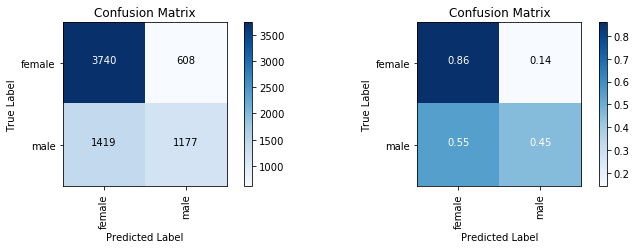

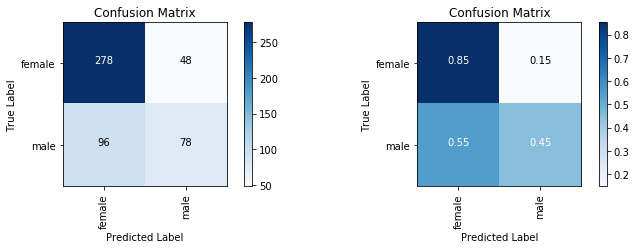

In [81]:
feat_num = 11
# evaluate the Naive Bayes classifier using gender_features11
train_accuracy_nb11,train_cm_nb11,train_label_names_nb11,train_report_nb11, \
    devtest_accuracy_nb11, devtest_cm_nb11,devtest_label_names_nb11, \
    devtest_report_nb11, classifier_nb11=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb11))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb11))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb11,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb11,['female','male'])

In [82]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb11.show_most_informative_features(n_informative_features)

Most Informative Features
                 count_v = 2              female : male   =      8.6 : 1.0
                 count_w = 1                male : female =      4.6 : 1.0
                 count_a = 3              female : male   =      4.5 : 1.0
                 count_k = 2              female : male   =      3.7 : 1.0
                 count_o = 2                male : female =      3.6 : 1.0
                 count_f = 2                male : female =      3.4 : 1.0
                 count_l = 3              female : male   =      3.3 : 1.0
                 count_i = 3                male : female =      3.1 : 1.0
                 count_a = 2              female : male   =      3.0 : 1.0
                 count_d = 3                male : female =      2.8 : 1.0
                 count_e = 3              female : male   =      2.8 : 1.0
                 count_p = 3              female : male   =      2.6 : 1.0
                 count_w = 2                male : female =      2.3 : 1.0

In [83]:
# Show error 
show_errors(generate_errors(classifier_nb11, devtest_names, feat_num))

correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Cherri                        
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Correna                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Dee Dee                       
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Dorolisa                      
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Fortune    

#### Feature 12 - Character Present  

In this model, we train a Naive Bayes classifier using presence of charcters.

Accuracy (Train): 0.690668202765
Accuracy (Development Test): 0.718


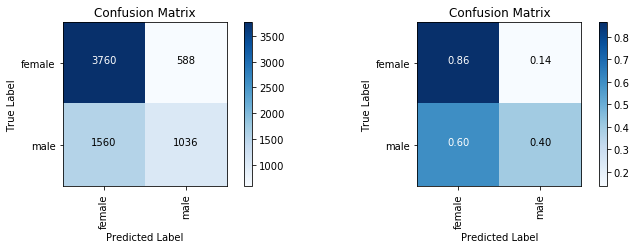

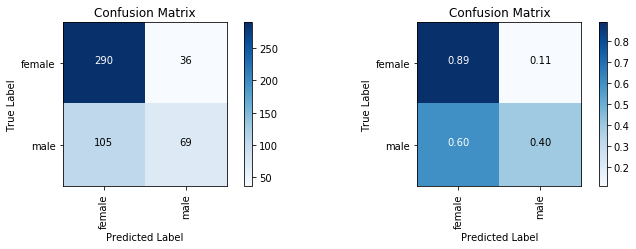

In [84]:
feat_num = 12
# evaluate the Naive Bayes classifier using gender_features12
train_accuracy_nb12,train_cm_nb12,train_label_names_nb12,train_report_nb12, \
    devtest_accuracy_nb12, devtest_cm_nb12,devtest_label_names_nb12, \
    devtest_report_nb12, classifier_nb12=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb12))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb12))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb12,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb12,['female','male'])

In [85]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb12.show_most_informative_features(n_informative_features)

Most Informative Features
                   has_w = True             male : female =      4.6 : 1.0
                   has_u = True             male : female =      1.8 : 1.0
                   has_p = True             male : female =      1.8 : 1.0
                   has_f = True             male : female =      1.6 : 1.0
                   has_o = True             male : female =      1.6 : 1.0
                   has_g = True             male : female =      1.5 : 1.0
                   has_a = False            male : female =      1.5 : 1.0
                   has_z = True             male : female =      1.4 : 1.0
                   has_i = True           female : male   =      1.4 : 1.0
                   has_h = True             male : female =      1.4 : 1.0
                   has_v = True             male : female =      1.4 : 1.0
                   has_a = True           female : male   =      1.3 : 1.0
                   has_i = False            male : female =      1.3 : 1.0

In [86]:
# Show error 
show_errors(generate_errors(classifier_nb12, devtest_names, feat_num))

correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Donny                         
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Fortune                       
correct=female   guess=male     name=Gertruda                      
correct=female   guess=male     name=Grethel                       
correct=female   guess=male     name=Gypsy                         
correct=female   guess=male     name=Hermione                      
correct=female   guess=male     name=Johnette                      
correct=female   guess=male     name=Jorey                         
correct=female   guess=male     name=Jorry      

#### Feature 13 - Count of each letter   

In this model, we train a Naive Bayes classifier using the count of each letter.

Accuracy (Train): 0.708093317972
Accuracy (Development Test): 0.712


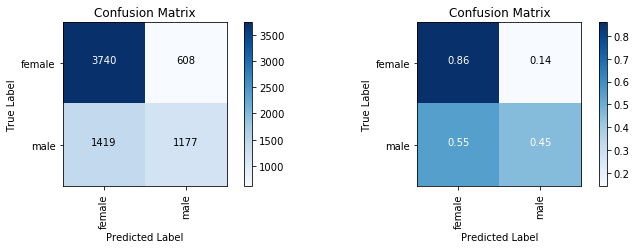

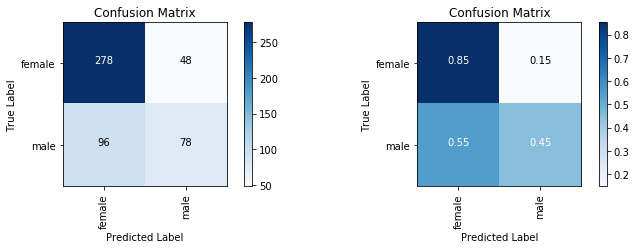

In [87]:
feat_num = 13
# evaluate the Naive Bayes classifier using gender_features13
train_accuracy_nb13,train_cm_nb13,train_label_names_nb13,train_report_nb13, \
    devtest_accuracy_nb13, devtest_cm_nb13,devtest_label_names_nb13, \
    devtest_report_nb13, classifier_nb13=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb13))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb13))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb13,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb13,['female','male'])

In [88]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb13.show_most_informative_features(n_informative_features)

Most Informative Features
                count(v) = 2              female : male   =      8.6 : 1.0
                count(w) = 1                male : female =      4.6 : 1.0
                count(a) = 3              female : male   =      4.5 : 1.0
                count(k) = 2              female : male   =      3.7 : 1.0
                count(o) = 2                male : female =      3.6 : 1.0
                count(f) = 2                male : female =      3.4 : 1.0
                count(l) = 3              female : male   =      3.3 : 1.0
                count(i) = 3                male : female =      3.1 : 1.0
                count(a) = 2              female : male   =      3.0 : 1.0
                count(d) = 3                male : female =      2.8 : 1.0
                count(e) = 3              female : male   =      2.8 : 1.0
                count(p) = 3              female : male   =      2.6 : 1.0
                count(w) = 2                male : female =      2.3 : 1.0

In [89]:
# Show error 
show_errors(generate_errors(classifier_nb13, devtest_names, feat_num))

correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Cherri                        
correct=female   guess=male     name=Chrysa                        
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Correna                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Dee Dee                       
correct=female   guess=male     name=Dido                          
correct=female   guess=male     name=Doloritas                     
correct=female   guess=male     name=Doris                         
correct=female   guess=male     name=Dorit                         
correct=female   guess=male     name=Dorolisa                      
correct=female   guess=male     name=Faustine                      
correct=female   guess=male     name=Fedora                        
correct=female   guess=male     name=Fortune    

#### Feature 14 - Count of Pair of letters  

In this model, we train a Naive Bayes classifier using the count of pair of letters.

Accuracy (Train): 0.759648617512
Accuracy (Development Test): 0.76


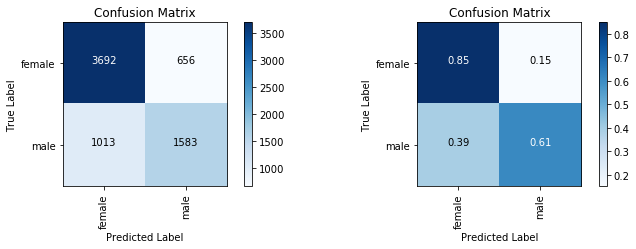

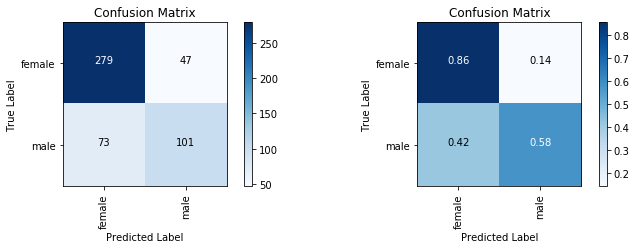

In [90]:
feat_num = 14
# evaluate the Naive Bayes classifier using gender_features2
train_accuracy_nb14,train_cm_nb14,train_label_names_nb14,train_report_nb14, \
    devtest_accuracy_nb14, devtest_cm_nb14,devtest_label_names_nb14, \
    devtest_report_nb14, classifier_nb14=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names,feat_num)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb14))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb14))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb14,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb14,['female','male'])

In [91]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb14.show_most_informative_features(n_informative_features)

Most Informative Features
                 has(fo) = True             male : female =     34.1 : 1.0
                 has(rk) = True             male : female =     24.0 : 1.0
                 has(hu) = True             male : female =     22.4 : 1.0
                 has(iu) = True             male : female =     17.3 : 1.0
                 has(rw) = True             male : female =     15.1 : 1.0
                 has(sp) = True             male : female =     14.0 : 1.0
                 has(lt) = True             male : female =     13.1 : 1.0
                 has(tc) = True             male : female =     12.8 : 1.0
                 has(wa) = True             male : female =     10.3 : 1.0
                 has(cu) = True             male : female =      9.5 : 1.0
                 has(ew) = True             male : female =      8.7 : 1.0
                 has(sk) = True             male : female =      7.7 : 1.0
                 has(wh) = True             male : female =      6.1 : 1.0

In [92]:
# Show error 
show_errors(generate_errors(classifier_nb14, devtest_names, feat_num))

correct=female   guess=male     name=Aime                          
correct=female   guess=male     name=Alberta                       
correct=female   guess=male     name=Ange                          
correct=female   guess=male     name=Astrid                        
correct=female   guess=male     name=Audry                         
correct=female   guess=male     name=Bamby                         
correct=female   guess=male     name=Barby                         
correct=female   guess=male     name=Berta                         
correct=female   guess=male     name=Cherri                        
correct=female   guess=male     name=Cordula                       
correct=female   guess=male     name=Daffi                         
correct=female   guess=male     name=Eddi                          
correct=female   guess=male     name=Emera                         
correct=female   guess=male     name=Esmerelda                     
correct=female   guess=male     name=Fedora     

#### Features Optimization    

In order to build the best possible Naive Baeyes Module, we will identify the best features based on accuracy rating.  


In [96]:
ranked_features = get_sorted_feature_accuracies(1, 14, 'nbc')

In [97]:
features = {
    1: "First Letter",
    2: "First 2 Letters",
    3: "Last Letter", 
    4: "Last 2 Letters", 
    5: "Last 3 Letters", 
    6: "Vowels count",
    7: "Hard consonants using general rules of c and g",
    8: "Soft consonants using general rules of c and g",
    9: "Syllable Count of names via textstat",
    10: "Name length",
    11: "Character count",
    12: "Character present",
    13: "Count of each letter",
    14: "Count of pair of letters in the alphabet",
}

print("Top Five Single Features with the Highest Accuracy")
print("---------------------------------------------------------------")
for (feat_num, accuracy) in ranked_features[0:5]:
    print('Feature: %-30s Accuracy: %-8s' %(features[feat_num], accuracy))

print("---------------------------------------------------------------")

Top Five Single Features with the Highest Accuracy
---------------------------------------------------------------
Feature: Last 2 Letters                 Accuracy: 0.786   
Feature: Last 3 Letters                 Accuracy: 0.768   
Feature: Last Letter                    Accuracy: 0.762   
Feature: Count of pair of letters in the alphabet Accuracy: 0.76    
Feature: Character present              Accuracy: 0.718   
---------------------------------------------------------------


Combining different features together can often lead to a more accurate classification system. The optmize_solution function was built to go through different combinations of classification features, and yield out a result of features that lead to the most accurate solution:

In [100]:
optimized_features = optimized_solution('nbc')
optimized_features


([1, 3, 4, 5, 6, 11], 0.83)

We see that the optmized solution yielded an accuracy of 0.826, while the highest accuracy achieved by any single feature was 0.788. The following features provided the optimized solution:

In [101]:
print("Following features provide the most optmized solution: ")
for feat_num in optimized_features[0]:
    print('    -> %-30s' %(features[feat_num]))

Following features provide the most optmized solution: 
    -> First Letter                  
    -> Last Letter                   
    -> Last 2 Letters                
    -> Last 3 Letters                
    -> Vowels count                  
    -> Character count               
